In [1]:
# %load_ext autotime
# !pip install autotime
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import os
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import torch

pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 100)
pd.set_option("max_colwidth", 100)

base_path = Path("/scratch/project/open-32-14/pimenol1/ProteinTTT/ProteinTTT/data/bfvd")
OUTPUT_PDB = base_path / Path('predicted_structures')
CLEAN_DF_PATH = base_path / Path('subset_1.tsv')
RESULTS_PATH = base_path / Path('results.tsv')

/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
len(os.listdir(OUTPUT_PDB))

388367

## Dataset

In [27]:
df_clean = pd.read_csv(CLEAN_DF_PATH, sep="\t")
results_old = pd.read_csv(RESULTS_PATH, sep="\t")
df_clean

,id,sequence,lenghth,pLDDT_after,pLDDT_before,tm_score_before,tm_score_after,lddt_before,lddt_after,plddt_AlphaFold,time
0,A0A2D1GNP4,MSEQIVVTDDENFSASWKVVSDAINDTKTVLDRSLAQLDGIAPPLPELQGVVVYNEGWLPTKPEPTDYTENPDGSVSFVDQQVIRTTPVPATDTAL...,279,NaN,NaN,NaN,NaN,NaN,NaN,27.544796,NaN
1,A0A0K1RMB7,VPGGFSTCNRHWNLNGSTFGWSSPRFAAIDHDRGNASFPGGSSSNVLELWYASAGSAADNPISQIAPDGFPDMSFVPFSGTTIPTAGWVGFGGIWN...,312,NaN,NaN,NaN,NaN,NaN,NaN,28.295470,NaN
2,A0A2I7RYJ4,MKGNIMNTFELSVINQEAHVALRLITTDGGAPQGTIADIREVTGVDVETCLAKVWNWFVNRERLALVSRDGTAFPYRGGKTFIKAALAFIEHNTPK...,207,NaN,NaN,NaN,NaN,NaN,NaN,29.216449,NaN
3,A0A075VR24,MYIYSMISLVLTITLSPSIHIISKRPAERLFFMYCWEHSSPFVNHLCTWTLSTVGYQNIHHPFVHFDECHLARRQPIPRFRVQINVGLRSQPLKQF...,234,NaN,NaN,NaN,NaN,NaN,NaN,30.046297,NaN
4,A0A1W6QDY9,MPYFGLNLLGSTVLDEFKNRFNSIKLVRLSLTMKAACQRPAWDDTYHHSGSVWSLPRLQFCMSHDAAEWQKHSTAIAGQECRKPVDTFLATKYNWR...,208,NaN,NaN,NaN,NaN,NaN,NaN,30.399183,NaN
...,...,...,...,...,...,...,...,...,...,...,...
79449,A0A6J5M0Y7,MTIVDLKASAYDCLAQIEYLQKQLQEINAKIAEELQKEKQENG,43,NaN,NaN,NaN,NaN,NaN,NaN,95.817006,NaN
79450,A0A7D7JJX1,MKNCIIFSGQYRTFGKTKENIKQFIALNDLDVYCHLWSVDESEINDIIENLQPKKILVEDFDCYKPYFESIESSIRFTNPKPSTMDILSNHASMNF...,229,NaN,NaN,NaN,NaN,NaN,NaN,96.029419,NaN
79451,A0A6J5SGW0,MAWRYEQKTGTLRDNRGAVVAQGYSGRDKGLNNPAAQGVANVGPIPVGTYDIATAMNHLSCGPLSMRLLPAPGTNTLGRDGFLIHGDTASMDHTAS...,124,NaN,NaN,NaN,NaN,NaN,NaN,96.332944,NaN
79452,G3MA51,MLYKDINPNKLDLTNKKAFLIDCDNTLGETMSSHNKAYELAFALNNVPFNLEEHEKWAPYGGKTLIQETVVNKGFSHLADDIVKDKQKLLPICLKK...,202,NaN,NaN,NaN,NaN,NaN,NaN,96.479361,NaN


In [28]:
results = pd.DataFrame(columns=df_clean.columns)
for file in os.listdir(base_path):
    if file.startswith("results_"):
        temp_df = pd.read_csv(base_path / file, sep="\t")
        results = pd.concat([results, temp_df.query("pLDDT_before.notna()")], ignore_index=True)
results

/tmp/ipykernel_3217990/1546108485.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, temp_df.query("pLDDT_before.notna()")], ignore_index=True)


,id,sequence,lenghth,pLDDT_after,pLDDT_before,tm_score_before,tm_score_after,lddt_before,lddt_after,plddt_AlphaFold,time
0,A0A2P0XMJ6,ATPHSWLFENESSETTLRRWLTTLAHLKELGSFGEEVYQFDTKQVEKFGPQGKVPPVSEGLETLEDSYSANEPDMWLPANYEEQCAKLAAILFGQE...,275,NaN,78.899287,0.82977,NaN,0.822516,NaN,86.908455,5.290520
1,A0A060AH21,MKMQSIVQRYENDITVEVHADKIEIQTWRMYMANFAPYKLYDEDFIWEVSLQKAIDLPTEILYNDFVMTTEYAMTFADFAKIMQRARVGITCLIH,95,73.799157,32.351623,0.53149,0.92151,0.510320,0.898711,86.908478,36.787787
2,A0A8S5M9T9,MGLKKTNYEVKDYGVTLPEAYAVITKLEIEGDNGRAEFSVQASPRANCFNLQSYERHFVNFKFTDRTKNPFEAAYLAAKETRKGEQFGREIEYKMP...,108,76.842836,57.709989,0.74308,0.87116,0.729367,0.883431,86.909271,36.595681
3,A0A481V8D8,MTTDQASIELDTPRRYAVRYEVFNDGDWEIVTDTIEADRVLPVGMSVCWHNTTTGASLVVSDEQLIASWTEEVSSRD,77,NaN,79.472977,0.87024,NaN,0.937222,NaN,86.909293,0.897346
4,A0A8D9PFK9,MQFLITILRTETIMIVLNRKHIRQNLQKWARYTR,34,70.949367,53.233567,0.48039,0.92108,0.832938,0.998431,86.909500,36.830692
...,...,...,...,...,...,...,...,...,...,...,...
210689,A0A345MUA0,MVLRYARKGKKGRKATRKPKMSFDKRVLSVINKQRELKVAVITGTEPINGTITGTDLQQILPDIAQADGEFNRDGNEITLKKIIVRGWITQTFPND...,246,NaN,79.033815,0.80307,NaN,0.795426,NaN,85.524595,3.557342
210690,A0A6J5PCF8,MGKFVQIKAATNNVEYVPVREIYRIVYAPDHNEYTLVMRDGESYTAYPVDVARLLDNDR,59,NaN,80.789442,0.88293,NaN,0.890665,NaN,85.524690,0.868444
210691,A0A077EKP3,MFREIGDFVDRFVPHLIYIYLMVLCAFLCLYYIQQHRRIREQHRYDLDQHIKVSVIAAESDHKP,64,NaN,77.374774,0.89571,NaN,0.998721,NaN,85.524702,0.871988
210692,A0A8F6UA82,FWKPKEVRETLLQSLISKFLTTKAAMSGSTVMRQSQSTKSFHNSVVGAEDNFEVTRGTRLTASLYYHQAMAFGNIVLDPSHHDFSSYIVHKDQVGN...,243,57.228116,51.470051,0.67861,0.65357,0.520099,0.527140,85.524772,98.813444


In [29]:
df = pd.concat([results_old, results], ignore_index=True)
df.shape[0], df.drop_duplicates('id').shape[0]

(433041, 222347)

In [30]:
df = df.drop_duplicates('id').reset_index(drop=True).sort_values('plddt_AlphaFold')
df.to_csv(RESULTS_PATH, sep="\t", index=False)

In [31]:
df_clean = df_clean[~df_clean.id.isin(df.id)]
df_clean.to_csv(CLEAN_DF_PATH, sep="\t", index=False)
df_clean.shape[0]

79454

In [9]:
df.query("pLDDT_after.notna() and pLDDT_after > plddt_AlphaFold")

,id,sequence,lenghth,pLDDT_after,pLDDT_before,tm_score_before,tm_score_after,lddt_before,lddt_after,plddt_AlphaFold,time
2,A0A1X9T5E4,MVLNVLVAFVSIGFLHTKAQIVCMPDLPGTALDSTTEPNSEMSYQYGPVALRYRYAALNTSVCTHIPTYPSVLTQLVKIASRDSHGIVIGDVMGDT...,347,38.066183,27.711835,0.19630,0.22774,0.541532,0.550518,24.872775,200.579467
3,A7ITD6,MRYDADTFPDAITFPNISVSKVLGTTPVTFEAFPEKYAAYILPVITIEFAIALPATMFPAVKKSVSTFPGADTFPTISMAAADGNVCVTSVRKNPF...,248,33.812316,24.619030,0.27418,0.18235,0.577954,0.596780,24.878686,100.703798
4,A0A3G5AAX1,MGQFHYFQKMSTSHESSSEFKNVMFCYNKVAPQPNSKCYNKVPPQANLKVPQQAGTTSEFENVTTRWDHKRIQKSYNKVAPQANSKMLQQSGTTRE...,154,29.844384,28.680760,0.21697,0.22829,0.531985,0.590236,25.188144,54.632020
5,A0A0C5KMH0,MEPERSTPMPSIPLLNRLGLARRGRGEERAGPTMPAQAQEPQKVPLLIKAARHFKSLLVQTEPERPETIPTIPELNYPALYTRYPVMKTVTKTTDA...,384,55.103655,42.110591,0.16564,0.16947,0.538551,0.554222,25.249915,237.006071
7,A0A8S5R5U9,MLRWCMWASLCAESGVFGVELHDVLRVHATGFQLLHHGLKERGAGHILDQLLRGEAGGVVEGFLADVLSVAGGGPGLLLLKGGVLNVVDQHGLDTG...,384,26.547066,22.501221,0.23977,0.23983,0.504948,0.510102,25.339497,239.871785
...,...,...,...,...,...,...,...,...,...,...,...
155806,A0A386KER0,MNVVNTLGTIVESAKAVNSVQEYKGKDKVNKGLSGASKALDIAAVILNILK,51,89.893073,55.842210,0.57097,0.91193,0.638060,0.942363,87.752749,35.414003
157667,A0A516KXN5,MFKVEIENQDKKTIITFTSETLAEAKALAEDQAAKALAQLANTTTVTAFVWNLKLGGIDAMLDSDGWC,68,90.116538,50.182689,0.71599,0.96082,0.554948,0.964174,87.930967,36.627290
157676,A0A0B6VNS2,MKRAEAIRNVAALVAVTAFSFSMFAGFMTGLLTTTENMVSLAVCAVVGGIAGVMHHIAK,59,88.533892,65.434741,0.76599,0.96202,0.676608,0.963495,87.932075,37.920949
158307,A0A2P1JYY0,MANTTTKRTTVPIPVDDPTPDSVWVQQARDSFEAYAVSWSLILLEFRDLGEGDPADYTEAAKQLGRPAADFRWRIFEGVFTRDLGA,86,88.473138,37.993886,0.24650,0.95072,0.344728,0.959640,88.043959,40.363035


In [10]:
df_clean

,id,sequence,lenghth,pLDDT_after,pLDDT_before,tm_score_before,tm_score_after,lddt_before,lddt_after,plddt_AlphaFold,time
0,A0A2D1GNP4,MSEQIVVTDDENFSASWKVVSDAINDTKTVLDRSLAQLDGIAPPLPELQGVVVYNEGWLPTKPEPTDYTENPDGSVSFVDQQVIRTTPVPATDTAL...,279,NaN,NaN,NaN,NaN,NaN,NaN,27.544796,NaN
1,A0A0K1RMB7,VPGGFSTCNRHWNLNGSTFGWSSPRFAAIDHDRGNASFPGGSSSNVLELWYASAGSAADNPISQIAPDGFPDMSFVPFSGTTIPTAGWVGFGGIWN...,312,NaN,NaN,NaN,NaN,NaN,NaN,28.295470,NaN
2,A0A2I7RYJ4,MKGNIMNTFELSVINQEAHVALRLITTDGGAPQGTIADIREVTGVDVETCLAKVWNWFVNRERLALVSRDGTAFPYRGGKTFIKAALAFIEHNTPK...,207,NaN,NaN,NaN,NaN,NaN,NaN,29.216449,NaN
3,A0A075VR24,MYIYSMISLVLTITLSPSIHIISKRPAERLFFMYCWEHSSPFVNHLCTWTLSTVGYQNIHHPFVHFDECHLARRQPIPRFRVQINVGLRSQPLKQF...,234,NaN,NaN,NaN,NaN,NaN,NaN,30.046297,NaN
4,A0A1W6QDY9,MPYFGLNLLGSTVLDEFKNRFNSIKLVRLSLTMKAACQRPAWDDTYHHSGSVWSLPRLQFCMSHDAAEWQKHSTAIAGQECRKPVDTFLATKYNWR...,208,NaN,NaN,NaN,NaN,NaN,NaN,30.399183,NaN
...,...,...,...,...,...,...,...,...,...,...,...
121536,A0A6J5M0Y7,MTIVDLKASAYDCLAQIEYLQKQLQEINAKIAEELQKEKQENG,43,NaN,NaN,NaN,NaN,NaN,NaN,95.817006,NaN
121579,A0A7D7JJX1,MKNCIIFSGQYRTFGKTKENIKQFIALNDLDVYCHLWSVDESEINDIIENLQPKKILVEDFDCYKPYFESIESSIRFTNPKPSTMDILSNHASMNF...,229,NaN,NaN,NaN,NaN,NaN,NaN,96.029419,NaN
121628,A0A6J5SGW0,MAWRYEQKTGTLRDNRGAVVAQGYSGRDKGLNNPAAQGVANVGPIPVGTYDIATAMNHLSCGPLSMRLLPAPGTNTLGRDGFLIHGDTASMDHTAS...,124,NaN,NaN,NaN,NaN,NaN,NaN,96.332944,NaN
121648,G3MA51,MLYKDINPNKLDLTNKKAFLIDCDNTLGETMSSHNKAYELAFALNNVPFNLEEHEKWAPYGGKTLIQETVVNKGFSHLADDIVKDKQKLLPICLKK...,202,NaN,NaN,NaN,NaN,NaN,NaN,96.479361,NaN


## Plots

Entries with lddt before and after: 48


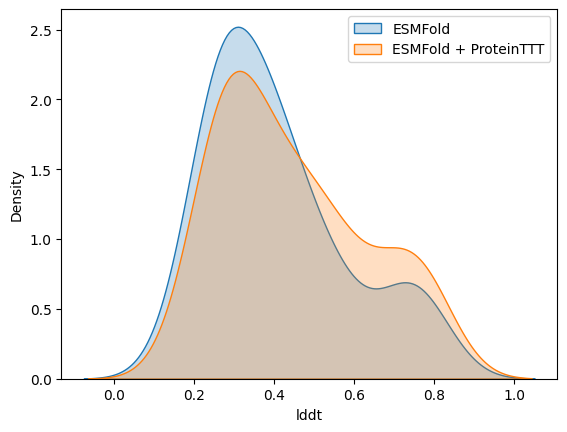

In [9]:
sub_df = df.query("lddt_before.notna() and lddt_after.notna()")
print(f"Entries with lddt before and after: {len(sub_df):,}")

sns.kdeplot(sub_df['lddt_before'], label='ESMFold', fill=True)
sns.kdeplot(sub_df['lddt_after'], label='ESMFold + ProteinTTT', fill=True)
# sns.kdeplot(sub_df['lddt_AlphaFold'], label='AlphaFold', fill=True)
plt.xlabel('lddt')
plt.legend()
plt.show()

In [8]:
sub_df.tm_score_after.describe(), sub_df.tm_score_before.describe()

(count    132.000000
 mean       0.512456
 std        0.191340
 min        0.237950
 25%        0.325765
 50%        0.502330
 75%        0.684365
 max        0.931900
 Name: tm_score_after, dtype: float64,
 count    132.000000
 mean       0.468230
 std        0.179125
 min        0.130300
 25%        0.319060
 50%        0.419685
 75%        0.631842
 max        0.827150
 Name: tm_score_before, dtype: float64)

In [12]:
df.lddt_after.describe(), df.lddt_before.describe()

(count    48.000000
 mean      0.446614
 std       0.180932
 min       0.185748
 25%       0.282080
 50%       0.407616
 75%       0.561028
 max       0.792706
 Name: lddt_after, dtype: float64,
 count    87.000000
 mean      0.504442
 std       0.239873
 min       0.163724
 25%       0.304979
 50%       0.415594
 75%       0.733089
 max       0.973206
 Name: lddt_before, dtype: float64)

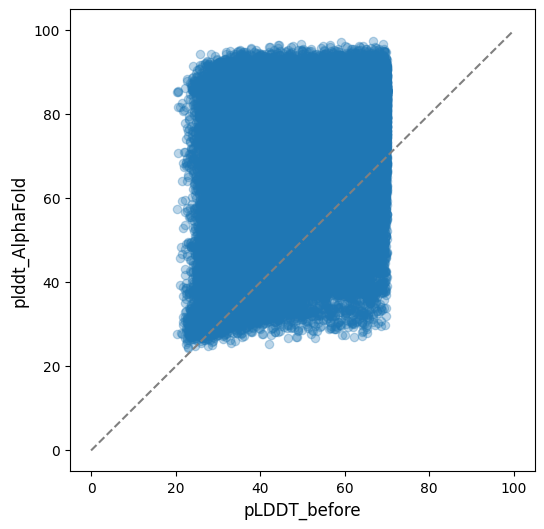

In [12]:
fig, ax = plt.subplots(figsize=(6, 6))
sc = ax.scatter(sub_df['pLDDT_before'], sub_df['plddt_AlphaFold'], alpha=0.3, linewidths=0.9)

ax.plot([0, 100], [0, 100], linestyle='--', color='grey', label='y=x')

ax.set_xlabel("pLDDT_before", fontsize=12)
ax.set_ylabel("plddt_AlphaFold", fontsize=12)
plt.show()

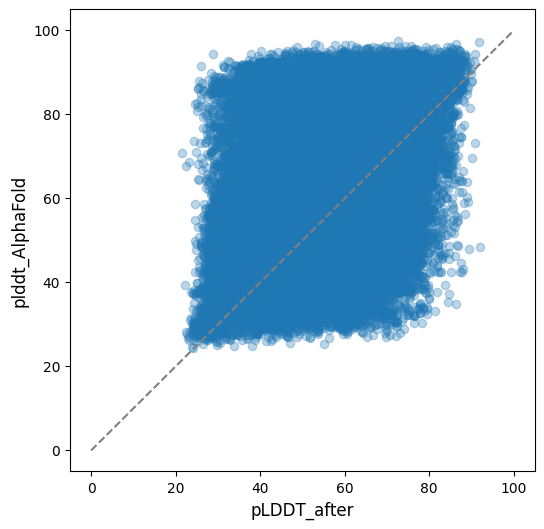

In [13]:
fig, ax = plt.subplots(figsize=(6, 6))
sc = ax.scatter(sub_df['pLDDT_after'], sub_df['plddt_AlphaFold'], alpha=0.3, linewidths=0.9)

ax.plot([0, 100], [0, 100], linestyle='--', color='grey', label='y=x')

ax.set_xlabel("pLDDT_after", fontsize=12)
ax.set_ylabel("plddt_AlphaFold", fontsize=12)
plt.show()

nan nan


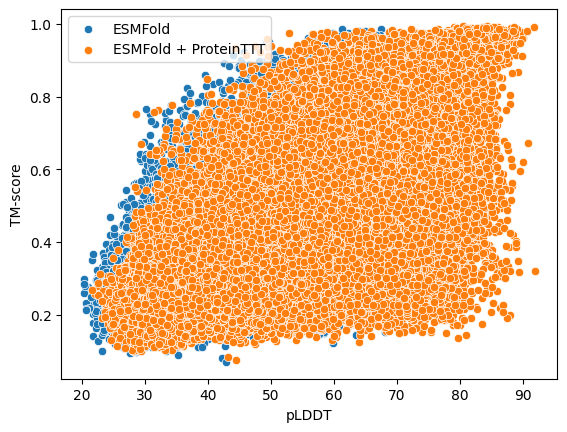

In [14]:
print(np.corrcoef(sub_df['pLDDT_before'], sub_df['tm_score_before'])[0, 1], np.corrcoef(sub_df['pLDDT_after'], y=sub_df['tm_score_after'])[0, 1])
sns.scatterplot(data=sub_df, x='pLDDT_before', y='tm_score_before', label='ESMFold')
sns.scatterplot(data=sub_df, x='pLDDT_after', y='tm_score_after', label='ESMFold + ProteinTTT')
plt.xlabel('pLDDT')
plt.ylabel('TM-score')
plt.legend()
plt.show()

nan nan


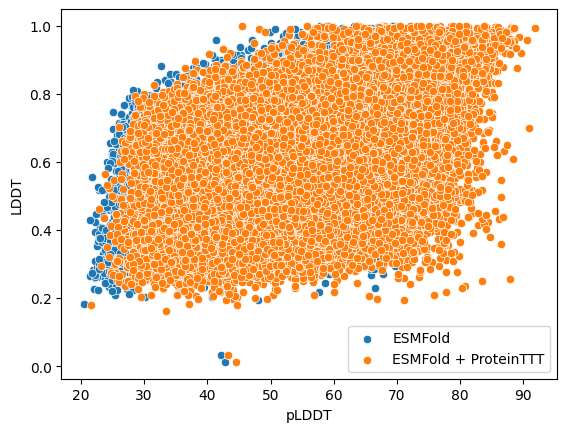

In [27]:
print(np.corrcoef(sub_df['pLDDT_before'], sub_df['lddt_before'])[0, 1], np.corrcoef(sub_df['pLDDT_after'], sub_df['lddt_after'])[0, 1])
sns.scatterplot(sub_df, x='pLDDT_before', y='lddt_before', label='ESMFold')
sns.scatterplot(sub_df, x='pLDDT_after', y='lddt_after', label='ESMFold + ProteinTTT')
plt.xlabel('pLDDT')
plt.ylabel('LDDT')
plt.legend()

In [28]:
sub_df['tm_score_difference'] = sub_df['tm_score_after'] - sub_df['tm_score_before']
plt.figure(figsize=(6, 6))
sns.boxplot(data=sub_df[['tm_score_difference']])
sns.swarmplot(data=sub_df[['tm_score_difference']], color=".25")
plt.ylabel('tm_score_difference')
# plt.xticks([0, 1], ['tm_score_difference'])
plt.show()

/tmp/ipykernel_1306274/709628841.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['tm_score_difference'] = sub_df['tm_score_after'] - sub_df['tm_score_before']


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x1472f54f05e0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [14]:
sub_df.pLDDT_before.describe(), sub_df.pLDDT_after.describe()

(count    78680.000000
 mean        49.027842
 std         12.158377
 min         20.331049
 25%         38.786255
 50%         48.721753
 75%         59.705194
 max         69.998968
 Name: pLDDT_before, dtype: float64,
 count    78680.000000
 mean        57.656607
 std         12.239061
 min         21.599748
 25%         48.463769
 50%         58.670126
 75%         67.542062
 max         91.803119
 Name: pLDDT_after, dtype: float64)

In [ ]:
sub_df

## Priority

In [ ]:
column_names = ['id', 'pdb_id', 'col1', 'col2', 'col3', 'col4', 'col5', 'col6', 'col7', 'col8', 'col9', 'col10']
df_100 = pd.read_csv(base_path / Path('bfvd_pdb100_mapping_lddt_nmsa_tophit.tsv'), sep='\t', names=column_names, header=None)
df_100

In [5]:
from proteinttt.utils.parsers import download_structure_and_extract_chain
df = pd.read_csv(base_path / Path('prior_out.tsv'), sep='\t')
df

,id,chain,chain_type,sequence,resolution,lenghth,pLDDT_after,pLDDT_before,tm_score_before,tm_score_after,lddt_before,lddt_after,plddt_AlphaFold
0,A0A068EP60,A,NaN,MSITKYSESAGPIGQSIYTFTGVTVPAQYMPRLVATTTVNKAGTNIEYKIAVNYPLVSVVDGANVALNTIRANLSFTALQSVINTDEKLRVLDEIV...,NaN,116,57.062431,44.714117,0.56515,0.68990,0.707223,0.801189,85.722385
1,A0A097I2D0,A,NaN,MSKAGKKVKAQQHGHLADHVSVGETQIPKASTQHLLRKAGSLSAAGDTEVPIRGFVHMKLHKLVQKSLLAMQLAKRKTIMKSDVKKAAELMHLPVF...,NaN,216,NaN,81.867753,0.81715,NaN,0.808683,NaN,79.719927
2,A0A0A0U955,A,NaN,MIDLRLEEDILTATLPEFLSTRPKYRYAYTNTKQQDIRFQGPMRHVRLTHLYKQTKLWNLQYIERELAISEIDDALDEFIQTFSLPYVIEQGTYKY...,NaN,1056,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,A0A0A1IVS8,A,NaN,MKSPYEAAHERALMVNRLQKLTRMLRVHPDPKWKQEQQELIKRLKK,NaN,46,NaN,84.480987,0.90924,NaN,0.978661,NaN,89.373722
4,A0A0X1KHD2,A,NaN,GPAFEFAVAMMKRNSSTVKTEYGEFTMLGIYDRWAVLPRHSKPGPTILMNDQEVGVLDAKELVDKDGTNLELTLLKLNRNEKFRDIRGFLAKEEVE...,NaN,180,NaN,87.086629,0.99644,NaN,0.991329,NaN,92.159366
...,...,...,...,...,...,...,...,...,...,...,...,...,...
288,UPI002249A336,A,NaN,FQHMGTVSWNLREMLAHAEETRKLMPVCVETKAIVSTIQRKYKGIKIQEGVVDYGARFYFYTSKTTVASLINTLNDLNETLVTMPLGYVTHGLNLE...,NaN,129,60.894505,36.735545,0.41014,0.35038,0.381455,0.327634,92.220317
289,UPI002249A33C,A,NaN,MEKTHVQLSLPVLQVRDVLVRGFGDSVEEVLSEARQHLKDGTCGLVEVEKGVLPQLEQPYVFIKRSDARTAPHGHVMVELVAELEGIQYGRSGETL...,NaN,118,43.609435,32.599739,0.27511,NaN,0.352780,NaN,85.082185
290,UPI0022AB4E73,A,NaN,GSHMYKSVNITFELDERIDKVLNEKCSAYTVELGTEVNEFACVVADAVIKTLQPVSELLTPLGIDLDEWSMATYYLFDESGEFKLASHMYCSFYPPDE,NaN,98,62.616521,45.697022,0.47669,0.43342,0.428792,0.403604,88.754365
291,UPI002348EE55,A,NaN,GNVTQAFGRRGPEQTQGNFGDQELIRQGTDYKHWPQIAQFAPSASAFFGMSRIGMEVTPSGTWLTYTGAIKLDDKDPNFKDQVILLNKHIDAYKTF...,NaN,100,41.450442,35.584463,0.40000,0.27390,0.494298,0.362563,85.793401


In [6]:
df = df.merge(df_100[['id', 'pdb_id']], on='id', how='left', suffixes=('', '_100'))

In [7]:
for i, row in df.iterrows():
    pdb = row['pdb_id'].split('_')[0]
    chain_id = row['pdb_id'].split('_')[1]
    # if len(chain_id) > 1:
    #     print(row['pdb_id'])
    #     continue
    df.loc[i, 'chain'] = chain_id
    df.loc[i, 'pdb'] = pdb
    # download_structure_and_extract_chain(pdb, chain_id, "/scratch/project/open-32-14/pimenol1/ProteinTTT/ProteinTTT/data/bfvd/correct_structure")
    

In [21]:
from proteinttt.utils.structure import calculate_tm_score, lddt_score, calculate_plddt
from proteinttt.utils.fix_pdb import fix_pdb

ORIGINAL_PDB = Path("/scratch/project/open-32-14/pimenol1/ProteinTTT/ProteinTTT/data/bfvd/correct_structure")


def calculate_all_metrics(df, pdb_pred_path=Path("/scratch/project/open-32-14/antonb/bfvd/bfvd")):
    new_rows = []
    for _, row in df.iterrows():
        pdb = row['pdb']
        chain = row['chain']
        seq_id = row['id']
        if len(chain) > 1:
            continue
        
        original_path = ORIGINAL_PDB / f"{pdb}_{chain}.pdb"
        pred_path_after = pdb_pred_path / f"{seq_id}_ttt.pdb"
        pred_path_before = pdb_pred_path / f"{seq_id}.pdb"
        
        # try:
        #     pLDDT_before = calculate_plddt(pred_path_before)
        # except Exception as e:
        #     pLDDT_before = None
        # try:
        #     pLDDT_after = calculate_plddt(pred_path_after)
        # except Exception as e:
        #     pLDDT_after = None

        try:
            fix_pdb(
                original_path,
                pred_path_before,
                chain,
                Path("/scratch/project/open-32-14/pimenol1/ProteinTTT/ProteinTTT/data/bfvd/fixed_pdb") / f"{pdb}_{chain}_before.pdb"
            )
        except Exception as e:
            # warnings.warn(f"Error processing {pdb}_{chain}: {e}")
            print(f"Error processing {pdb}_{chain}: {e}")
            # if "Length mismatch" in str(e):
            #     c+=1
            continue
        try:
            fix_pdb(
                original_path,
                pred_path_after,
                chain,
                Path("/scratch/project/open-32-14/pimenol1/ProteinTTT/ProteinTTT/data/bfvd/fixed_pdb") / f"{pdb}_{chain}_after.pdb"
            )
        except Exception as e:
            print(f"Error processing {pdb}_{chain}: {e}")
            continue
    
        try:
            lddt_before = lddt_score(pdb_ref=original_path, pdb_model=Path("/scratch/project/open-32-14/pimenol1/ProteinTTT/ProteinTTT/data/bfvd/fixed_pdb") / f"{pdb}_{chain}_before.pdb")
        except Exception as e:
            lddt_before = None
            print(f"Error calculating lddt_before for {seq_id}: {e}")
        try:
            lddt_after: float = lddt_score(pdb_ref=original_path, pdb_model=Path("/scratch/project/open-32-14/pimenol1/ProteinTTT/ProteinTTT/data/bfvd/fixed_pdb") / f"{pdb}_{chain}_after.pdb")
        except Exception as e:
            lddt_after = None
            print(f"Error calculating lddt_before for {seq_id}: {e}")


        # try:
        #     tm_score_before = calculate_tm_score(pred_path=pred_path_before, pdb_path=original_path)
        # except ValueError as e:
        #     tm_score_before = None
        # try:
        #     tm_score_after = calculate_tm_score(pred_path=pred_path_after, pdb_path=original_path)
        # except ValueError as e:
        #     tm_score_after = None

        new_rows.append({
            'pdb': pdb,
            'chain': chain,
            # 'sequence': row['sequence'],
            # 'chain_type': row['chain_type'],
            # 'resolution': row['resolution'],
            # 'pLDDT_before': pLDDT_before,
            # 'pLDDT_after': pLDDT_after,
            # 'tm_score_before': tm_score_before,
            # 'tm_score_after': tm_score_after,
            'lddt_before': lddt_before,
            'lddt_after': lddt_after
        })

    return pd.DataFrame(new_rows)

In [ ]:
# df.drop(columns=['chain', 'chain_type', 'resolution'], inplace=True)
# df['chain'] = None

In [49]:
df

,id,sequence,lenghth,pLDDT_after,pLDDT_before,tm_score_before,tm_score_after,lddt_before,lddt_after,plddt_AlphaFold,pdb_id,pdb,chain
0,A0A068EP60,MSITKYSESAGPIGQSIYTFTGVTVPAQYMPRLVATTTVNKAGTNIEYKIAVNYPLVSVVDGANVALNTIRANLSFTALQSVINTDEKLRVLDEIV...,116,57.062431,44.714117,0.56515,0.68990,0.707223,0.801189,85.722385,6yf7_AA,6yf7,AA
1,A0A097I2D0,MSKAGKKVKAQQHGHLADHVSVGETQIPKASTQHLLRKAGSLSAAGDTEVPIRGFVHMKLHKLVQKSLLAMQLAKRKTIMKSDVKKAAELMHLPVF...,216,NaN,81.867753,0.81715,NaN,0.808683,NaN,79.719927,7n8n_C,7n8n,C
2,A0A0A0U955,MIDLRLEEDILTATLPEFLSTRPKYRYAYTNTKQQDIRFQGPMRHVRLTHLYKQTKLWNLQYIERELAISEIDDALDEFIQTFSLPYVIEQGTYKY...,1056,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6djy_D,6djy,D
3,A0A0A1IVS8,MKSPYEAAHERALMVNRLQKLTRMLRVHPDPKWKQEQQELIKRLKK,46,NaN,84.480987,0.90924,NaN,0.978661,NaN,89.373722,6yse_A,6yse,A
4,A0A0X1KHD2,GPAFEFAVAMMKRNSSTVKTEYGEFTMLGIYDRWAVLPRHSKPGPTILMNDQEVGVLDAKELVDKDGTNLELTLLKLNRNEKFRDIRGFLAKEEVE...,180,NaN,87.086629,0.99644,NaN,0.991329,NaN,92.159366,5bpe_A,5bpe,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...
288,UPI002249A336,FQHMGTVSWNLREMLAHAEETRKLMPVCVETKAIVSTIQRKYKGIKIQEGVVDYGARFYFYTSKTTVASLINTLNDLNETLVTMPLGYVTHGLNLE...,129,60.894505,36.735545,0.41014,0.35038,0.381455,0.327634,92.220317,7xc3_A,7xc3,A
289,UPI002249A33C,MEKTHVQLSLPVLQVRDVLVRGFGDSVEEVLSEARQHLKDGTCGLVEVEKGVLPQLEQPYVFIKRSDARTAPHGHVMVELVAELEGIQYGRSGETL...,118,43.609435,32.599739,0.27511,NaN,0.352780,NaN,85.082185,8a55_A,8a55,A
290,UPI0022AB4E73,GSHMYKSVNITFELDERIDKVLNEKCSAYTVELGTEVNEFACVVADAVIKTLQPVSELLTPLGIDLDEWSMATYYLFDESGEFKLASHMYCSFYPPDE,98,62.616521,45.697022,0.47669,0.43342,0.428792,0.403604,88.754365,8hda_B,8hda,B
291,UPI002348EE55,GNVTQAFGRRGPEQTQGNFGDQELIRQGTDYKHWPQIAQFAPSASAFFGMSRIGMEVTPSGTWLTYTGAIKLDDKDPNFKDQVILLNKHIDAYKTF...,100,41.450442,35.584463,0.40000,0.27390,0.494298,0.362563,85.793401,7n0i_H,7n0i,H


In [24]:
df_new = calculate_all_metrics(df)
df_new

Error processing 7n8n_C: Length mismatch: original 197, predicted 216, /scratch/project/open-32-14/antonb/bfvd/bfvd/A0A097I2D0.pdb
Sequence matches exactly.
Error processing 6djy_D: [Errno 2] No such file or directory: '/scratch/project/open-32-14/antonb/bfvd/bfvd/A0A0A0U955_ttt.pdb'
Sequence matches exactly.
Error processing 6yse_A: [Errno 2] No such file or directory: '/scratch/project/open-32-14/antonb/bfvd/bfvd/A0A0A1IVS8_ttt.pdb'
Sequence matches exactly.
Error processing 5bpe_A: [Errno 2] No such file or directory: '/scratch/project/open-32-14/antonb/bfvd/bfvd/A0A0X1KHD2_ttt.pdb'
Error processing 5c2n_O: Length mismatch: original 46, predicted 48, /scratch/project/open-32-14/antonb/bfvd/bfvd/A0A140UHM9.pdb
Error processing 7um0_c: Length mismatch: original 484, predicted 496, /scratch/project/open-32-14/antonb/bfvd/bfvd/A0A172JI16.pdb
Error processing 6exp_F: Length mismatch: original 103, predicted 96, /scratch/project/open-32-14/antonb/bfvd/bfvd/A0A1B3SN05.pdb
Error processing 

KeyboardInterrupt: 

In [1]:
# df_new.to_csv(base_path / Path('prior_out_with_metrics.tsv'), sep="\t", index=False)

In [5]:
df_1 = pd.read_csv(base_path / Path('prior_out.tsv'), sep='\t')
df_2 = pd.read_csv(base_path / Path('prior_out_with_metrics.tsv'), sep='\t')

In [14]:
df_2.head(1)

,pdb,chain,pLDDT_before,pLDDT_after,tm_score_before,tm_score_after,lddt_before,lddt_after,pdb_id
0,7n8n,C,81.867753,NaN,0.76943,NaN,NaN,NaN,7n8n_C


In [23]:
df.to_csv(base_path / Path('priority_sequences.tsv'), sep="\t", index=False)

In [20]:
df.query("pdb == '1b35'")

,pdb,chain,pLDDT_before,pLDDT_after,tm_score_before,tm_score_after,lddt_before,lddt_after
37,1b35,A,66.379344,66.608037,0.78821,0.79259,0.736847,0.71703
38,1b35,B,61.031137,69.481873,0.16058,0.68217,NaN,NaN
39,1b35,C,65.558764,67.039014,0.75813,0.79145,NaN,NaN


## Renumbering for lddt

In [ ]:
c = 0
for i, row in df.iterrows():
    try:
        pdb = row['pdb']
        chain = row['chain']
    except IndexError:
        continue

    if len(chain) != 1:
        print(f"Chain {chain} in {pdb} is not a single character, skipping.")
        continue

    # if df_diff.query(f"pdb == '{pdb}' and chain == '{chain}'").shape[0] != 0:
    #     continue

    try:
        fix_pdb(
            ORIGINAL_PDB / f"{pdb}.pdb",
            PREDICTED_PDB / f"{pdb}_{chain}.pdb",
            chain,
            CORRECT_PREDICTED_PDB / f"{pdb}_{chain}.pdb"
        )
    except Exception as e:
        warnings.warn(f"Error processing {pdb}_{chain}: {e}")
        # if "Length mismatch" in str(e):
        #     c+=1
        continue